In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay

In [2]:
def create_list(dir,isImage=True,sort=False,fullPath=False):
  """
  Create list given directory.
  """
  lst = os.listdir(dir)

  if sort:
    lst = sort_list(lst,isImage)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

## To manipulate data.
def sort_list(lst,isImage:bool=True):
  """
  Sort given list
  isImage used to check for images list or json list is given.
  """
  if not isImage:
    s = 5
  else:
    s = 4
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-s:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def create_dict(keys,values):
  """
  Return created dictionary.
  """
  dictionary = {}
  for i,k in enumerate(keys):
    dictionary[k] = values[i]
  return dictionary

def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  """
  create dictionary with images as keys and excel labels as values.
  Image list must be sorted before call this function.
  For sorting call sort_image_list function before.
  """
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

def display_images_labels(imgs_lst,image_label_dictionary):
  """
  Return dataframe contains images and corresponding labels.
  """
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def get_selected_indexes(indexs:list,elements_list:list):
  """
  Get elements from elemnts list given their indexs.
  """
  arr = []
  for idx in indexs:
    arr.append(elements_list[idx])
  return arr

def get_values(keys,dictionary):
  """
  Given  keys, returns values from dictionary.
  """
  arr = []
  for key in keys:
    arr.append(dictionary[key])
  return arr

## For controls.
def search(arr,start_index,element):
  """
  Search for elemnt in given Arrays.
  If found returns searched element, else returns -1.
  """
  if element ==-1:
    j=start_index+1
    element = arr[start_index]
  else:
    j=0
  while j<len(arr):
    if element == arr[j]:
      return element
    else:
      j+=1
  return -1

def getNotFoundElements(arr1,arr2):
  """
  Given aar1, returns elements that not found in arr2.
  """
  not_found= []
  for elm in arr1:
    xx = search(arr2,-1,elm)
    if xx ==-1:
      not_found.append(elm)
  return not_found

def create_cm(actual_labels,predicted,classes,title="Confusion Matrix"):
  """
  Create Confusion Matrix.
  """
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title(title)
  plt.show()

def calculate_metrics(labels,predictions):
  precision = precision_score(labels,predictions)
  recall = recall_score(labels,predictions)
  accuracy = accuracy_score(labels,predictions)
  return accuracy, precision, recall

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
goruntuJsonPath = "/content/drive/MyDrive/Ara_proje_dataset/Models/DeiTImagesEmbs_butun_goruntu.json"
mandibulaJsonPath = "/content/drive/MyDrive/Ara_proje_dataset/Models/DeiT_Embs_mandibular.json"
images_dir = "/content/drive/MyDrive/Ara_proje_dataset/all_images"
excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
classes = ("Hatasiz" , "Hatali")

labels = pd.read_excel(excel_path,header=None,keep_default_na=False)
images = create_list(images_dir,sort=True)
img_lbl_dict = create_img_label_dict(images,labels,column_num=1)
print("labels file length =", len(labels))
print("images list length =", len(images))
print("dictionary  length =", len(img_lbl_dict))
display_images_labels(images,img_lbl_dict)

labels file length = 1497
images list length = 1497
dictionary  length = 1497


,Image,Label
0,1.jpg,0
1,2.jpg,1
2,3.jpg,1
3,4.jpg,0
4,5.jpg,1
...,...,...
1492,3554.bmp,1
1493,3555.bmp,0
1494,3556.bmp,0
1495,3557.bmp,0


In [4]:
with open(goruntuJsonPath,"r") as file:
  goruntuEmbs = json.load(file)

with open(mandibulaJsonPath,"r") as file:
  mandibulaEmbs = json.load(file)

print(f"Butun Goruntu Embeddings: {len(goruntuEmbs)}")
print(f"Mandibula Embeddings: {len(mandibulaEmbs)}")

Butun Goruntu Embeddings: 1497
Mandibula Embeddings: 1497


In [5]:
def get_max_index(a,b):
  if a>b:
    return 0
  else:
    return 1

def combineModels(goruntu_probs,mandibula_probs,labels):
  final_preds = []
  for i in range(len(labels)):
    mand_pred = get_max_index(mandibula_probs[i][0],mandibula_probs[i][1])
    bGoruntu_pred = get_max_index(goruntu_probs[i][0],goruntu_probs[i][1])

    if mand_pred == bGoruntu_pred:
      final_preds.append(mand_pred)
    else:
      if mandibula_probs[i][mand_pred] > goruntu_probs[i][bGoruntu_pred]:
        final_preds.append(mand_pred)
      else:
        final_preds.append(bGoruntu_pred)

    #print(f"image name {images[i]}")
    #print(f"mandibula: {mand_pred}, {mand_probs[i]}")
    #print(f"butun goruntu: {bGoruntu_pred}, {goruntu_probs[i]}")
    #print(f"Predicted: {final_pred[i]}, True: {labels[i]}")
  return final_preds

In [6]:
def predict(embeddings,images,y_train):
  clf = svm.SVC(kernel="rbf",probability=True,gamma='scale')             ## Initialize classifier
  ## Getting selected images for train/test folds.
  x_train = get_selected_indexes(train_index,images)
  x_test  = get_selected_indexes(test_index,images)

  ## getting embedding values of each image from embeddings dictionary.
  train_embs = get_values(x_train,embeddings)
  test_embs = get_values(x_test,embeddings)

  ## Converting embeddings to numby array.
  train_embsLst = np.array(train_embs)
  test_embsLst = np.array(test_embs)

  ## Fitting data to models.
  model = clf.fit(train_embsLst,y_train)
  preds = model.predict_proba(test_embsLst)

  return preds

In [9]:
K = 5                                  ## Number of folds
kf = KFold(n_splits=K)                 ## Define K-Fold method for cross validation
#########################################
## Training loop
metrics = []
predicted_lbls = []
actual_lbls = []
for i, (train_index, test_index) in enumerate(kf.split(images)):
  print(f"Fold {i+1}/{K}")

  ## Getting selected images for train/test folds.
  x_train = get_selected_indexes(train_index,images)
  x_test  = get_selected_indexes(test_index,images)

  ## Getting labels.
  y_train = get_values(x_train,img_lbl_dict)
  y_test = get_values(x_test,img_lbl_dict)

  ## Bütün görüntü kullanarak prediction yapma.
  bGoruntu_preds = predict(goruntuEmbs,images,y_train)

  ## Mandibula kullanarak prediction yapma.
  mand_preds = predict(mandibulaEmbs,images,y_train)

  ## Predicting final predictions by combining two models
  predictions = combineModels(bGoruntu_preds,mand_preds,y_test)

  res = calculate_metrics(y_test,predictions)

  predicted_lbls.extend(predictions)
  actual_lbls.extend(y_test)
  metrics.append(res)
  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")


Fold 1/5
Accuracy: 0.5933333333333334, Precision: 0.5197368421052632, Recall: 0.6171875
Fold 2/5
Accuracy: 0.65, Precision: 0.631578947368421, Recall: 0.6620689655172414
Fold 3/5
Accuracy: 0.6789297658862876, Precision: 0.7873563218390804, Recall: 0.6989795918367347
Fold 4/5
Accuracy: 0.5250836120401338, Precision: 0.49814126394052044, Recall: 0.950354609929078
Fold 5/5
Accuracy: 0.6287625418060201, Precision: 0.7777777777777778, Recall: 0.6071428571428571


Average Accuracy : 61.5221850613155
Average Precision 64.29182306062125
Average Recall 70.71467048851824
Total test images: 1497


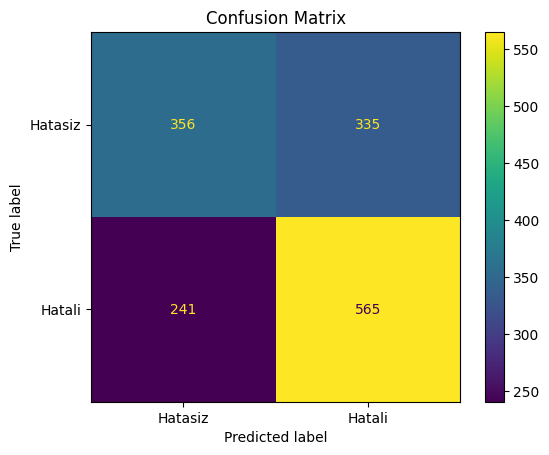

In [10]:
avg_acc, avg_precision, avg_recall= 0.0, 0.0, 0.0
for i in range(K):
    avg_acc += metrics[i][0]
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K

## Print Train metrics results
print("Average Accuracy :", avg_acc)
print("Average Precision", avg_precision)
print("Average Recall", avg_recall)
print(f"Total test images: {len(predicted_lbls)}")

## Draw confusion matrix
create_cm(actual_lbls,predicted_lbls,classes)